In [2]:
from google.cloud import bigquery
import pandas

In [3]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: ut-goog


In [29]:
query = """
    SELECT 
        date_received, product, subproduct, issue, subissue, consumer_complaint_narrative, company_public_response, company_name, state 
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

complaints_df = query_job.to_dataframe()
complaints_df

,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state
0,2019-12-15,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Fraud or scam,None,None,None,"Early Warning Services, LLC",CO
1,2020-01-31,"Money transfer, virtual currency, or money ser...",Refund anticipation check,Fraud or scam,None,None,None,"Credit Karma, Inc.",CA
2,2019-12-12,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,None,None,"Paypal Holdings, Inc",HI
3,2019-12-30,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Fraud or scam,None,None,None,Square Inc.,DE
4,2020-01-14,"Money transfer, virtual currency, or money ser...",International money transfer,Fraud or scam,None,None,None,JPMORGAN CHASE & CO.,OH
...,...,...,...,...,...,...,...,...,...
1498054,2019-02-09,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,None,None,"Conn's, Inc.",TX
1498055,2018-11-10,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Problem with personal statement of dispute,None,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FM
1498056,2019-02-15,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,None,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",IL
1498057,2019-02-19,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,None,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",WA


# Looking at null values by column
Percentage of missing values by columns

In [36]:
(complaints_df.isnull().sum()/len(complaints_df)*100).sort_values(ascending=False)

consumer_complaint_narrative    67.180532
company_public_response         62.458755
subissue                        37.234181
subproduct                      15.697980
state                            1.671162
company_name                     0.000000
issue                            0.000000
product                          0.000000
date_received                    0.000000
dtype: float64

### Can see that the narrative is the highest missing. 

In [39]:
(len(complaints_df)-complaints_df.isnull().sum()).sort_values()

consumer_complaint_narrative     491655
company_public_response          562390
subissue                         940269
subproduct                      1262894
state                           1473024
date_received                   1498059
product                         1498059
issue                           1498059
company_name                    1498059
dtype: int64

### We have 491,655 complaint narratives that we can use the NLP API on.

In [43]:
complaints_df.dtypes

date_received                   object
product                         object
subproduct                      object
issue                           object
subissue                        object
consumer_complaint_narrative    object
company_public_response         object
company_name                    object
state                           object
dtype: object

### Looking at Products and Subproducts

In [4]:
query = """
    SELECT 
        product, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        product
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

products_df = query_job.to_dataframe()
products_df

,product,total
0,"Credit reporting, credit repair services, or o...",337611
1,Mortgage,294932
2,Debt collection,279415
3,Credit reporting,140432
4,Credit card,89190
5,Bank account or service,86206
6,Credit card or prepaid card,67649
7,Checking or savings account,57325
8,Student loan,56330
9,Consumer Loan,31604


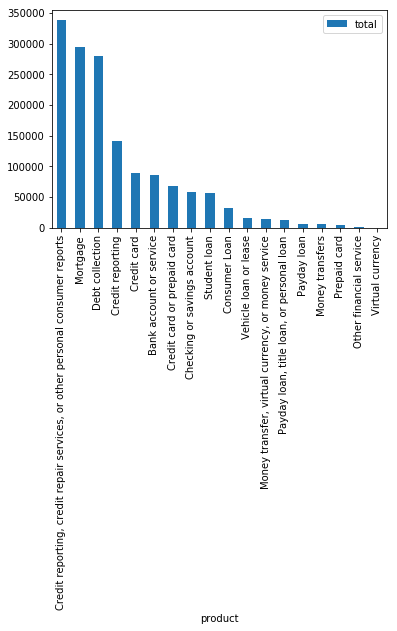

In [5]:
products_df.plot(kind="bar",x='product')

### Look at and maybe combine some of the products?

In [6]:
query = """
    SELECT 
        company_name, product, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        company_name, product
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

products2_df = query_job.to_dataframe()

In [10]:
products2_df[:10]

,company_name,product,total
0,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...",98159
1,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","Credit reporting, credit repair services, or o...",86689
2,Experian Information Solutions Inc.,"Credit reporting, credit repair services, or o...",84591
3,"EQUIFAX, INC.",Credit reporting,48128
4,Experian Information Solutions Inc.,Credit reporting,45378
5,"BANK OF AMERICA, NATIONAL ASSOCIATION",Mortgage,43649
6,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Credit reporting,39821
7,WELLS FARGO & COMPANY,Mortgage,38007
8,Ocwen Financial Corporation,Mortgage,27753
9,"Navient Solutions, LLC.",Student loan,26940


In [7]:
products2_df[products2_df['company_name']=='EQUIFAX, INC.']

,company_name,product,total
0,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...",98159
3,"EQUIFAX, INC.",Credit reporting,48128
89,"EQUIFAX, INC.",Debt collection,2444
726,"EQUIFAX, INC.",Credit card or prepaid card,156
1286,"EQUIFAX, INC.",Mortgage,74
1554,"EQUIFAX, INC.",Consumer Loan,55
1726,"EQUIFAX, INC.",Credit card,46
1871,"EQUIFAX, INC.",Student loan,41
2223,"EQUIFAX, INC.",Vehicle loan or lease,30
3346,"EQUIFAX, INC.",Bank account or service,14


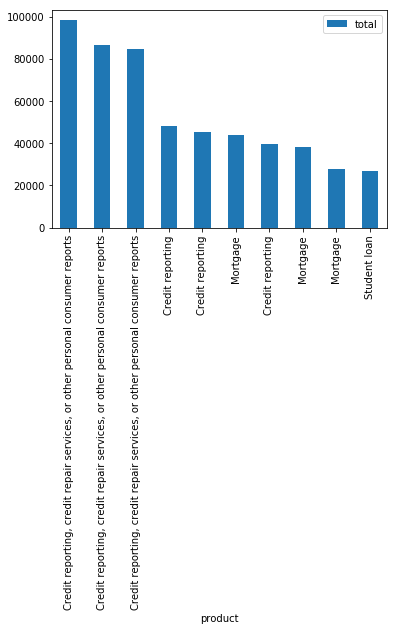

In [9]:
products2_df[:10].plot(kind='bar',x='product')

Most complaints for the companies seem to be about credit cards or credit

### Lets look at subproducts to see if there is a reason for the different product types

In [8]:
query = """
    SELECT 
        subproduct, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        subproduct
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

subproducts_df = query_job.to_dataframe()
subproducts_df

,subproduct,total
0,Credit reporting,331681
1,None,235165
2,Checking account,102248
3,Other mortgage,86635
4,Conventional fixed mortgage,70613
...,...,...
72,Credit repair,103
73,Traveler’s/Cashier’s checks,88
74,Transit card,37
75,Electronic Benefit Transfer / EBT card,12


In [13]:
query = """
    SELECT 
        product, subproduct, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        product, subproduct
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

products3_df = query_job.to_dataframe()
products3_df[:20]

,product,subproduct,total
0,"Credit reporting, credit repair services, or o...",Credit reporting,331681
1,Credit reporting,None,140432
2,Credit card,None,89190
3,Mortgage,Other mortgage,86635
4,Mortgage,Conventional fixed mortgage,70613
5,Bank account or service,Checking account,59045
6,Debt collection,I do not know,57805
7,Credit card or prepaid card,General-purpose credit card or charge card,52260
8,Debt collection,"Other (i.e. phone, health club, etc.)",44543
9,Checking or savings account,Checking account,43203


Notice row 6, "I do not know". What does this mean? Looks like we can combine some subproducts, ie credit card debt and credit card or medical debt and medical

In [18]:
products3_df[products3_df['product'] == 'Credit card or prepaid card']

,product,subproduct,total
7,Credit card or prepaid card,General-purpose credit card or charge card,52260
24,Credit card or prepaid card,Store credit card,11232
54,Credit card or prepaid card,General-purpose prepaid card,2448
63,Credit card or prepaid card,Government benefit card,1154
76,Credit card or prepaid card,Payroll card,280
77,Credit card or prepaid card,Gift card,269
96,Credit card or prepaid card,Student prepaid card,6


The just credit card product has no subproduct but the one that combines credit card and prepaid card does. Do they mean different things?

# Looking at issues and subissues

In [21]:
query = """
    SELECT 
        issue, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        issue
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

issue_df = query_job.to_dataframe()
issue_df[:10]

,issue,total
0,Incorrect information on your report,208943
1,"Loan modification,collection,foreclosure",112309
2,Incorrect information on credit report,102686
3,"Loan servicing, payments, escrow account",77333
4,Problem with a credit reporting company's inve...,76617
5,Cont'd attempts collect debt not owed,60682
6,Attempts to collect debt not owed,60039
7,Improper use of your report,42263
8,Communication tactics,38908
9,"Account opening, closing, or management",37961


Can see some looks repetitive.

In [23]:
query = """
    SELECT 
        company_name, issue, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        company_name, issue
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

issue2_df = query_job.to_dataframe()
issue2_df[:10]

,company_name,issue,total
0,"EQUIFAX, INC.",Incorrect information on your report,56389
1,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Incorrect information on your report,54708
2,Experian Information Solutions Inc.,Incorrect information on your report,52996
3,"EQUIFAX, INC.",Incorrect information on credit report,34468
4,Experian Information Solutions Inc.,Incorrect information on credit report,32486
5,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Incorrect information on credit report,30325
6,"BANK OF AMERICA, NATIONAL ASSOCIATION","Loan modification,collection,foreclosure",25075
7,"EQUIFAX, INC.",Problem with a credit reporting company's inve...,21600
8,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Problem with a credit reporting company's inve...,19848
9,Experian Information Solutions Inc.,Problem with a credit reporting company's inve...,19838


In [25]:
query = """
    SELECT 
        subissue, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        subissue
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

subissue_df = query_job.to_dataframe()
subissue_df[:10]

,subissue,total
0,None,557790
1,Information belongs to someone else,107650
2,Their investigation did not fix an error on yo...,56163
3,Account status,37057
4,Debt is not mine,36727
5,Account status incorrect,35556
6,Information is not mine,32384
7,Account information incorrect,32260
8,Debt is not yours,31319
9,Debt was paid,29242


debt is not mine and debt is not yours seem to be the same thing?

In [27]:
query = """
    SELECT 
        issue, subissue, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        issue, subissue
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

subissue2_df = query_job.to_dataframe()
subissue2_df[:15]

,issue,subissue,total
0,"Loan modification,collection,foreclosure",None,112309
1,Incorrect information on your report,Information belongs to someone else,107650
2,"Loan servicing, payments, escrow account",None,77333
3,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,55885
4,"Account opening, closing, or management",None,37961
5,Incorrect information on credit report,Account status,37057
6,Cont'd attempts collect debt not owed,Debt is not mine,36727
7,Incorrect information on your report,Account status incorrect,35556
8,Incorrect information on credit report,Information is not mine,32384
9,Incorrect information on your report,Account information incorrect,32260


# Looking At Which Companies Had The Most Complaint

In [3]:
query = """
    SELECT 
        company_name, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        company_name
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

companies_df = query_job.to_dataframe()
companies_df

,company_name,total
0,"EQUIFAX, INC.",149170
1,Experian Information Solutions Inc.,132774
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",129341
3,"BANK OF AMERICA, NATIONAL ASSOCIATION",88209
4,WELLS FARGO & COMPANY,76226
...,...,...
5527,Handshake Home Loans Inc.,1
5528,"1st United Funding, LLC",1
5529,"Portview Billing Services, LLC",1
5530,Money Tree Lending,1


In [13]:
query = """
    SELECT 
        company_name, COUNT(complaint_id) as total, (COUNT(complaint_id)/1498059)*100 as percentage
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        company_name
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

companies_df2 = query_job.to_dataframe()
companies_df2

,company_name,total,percentage
0,"EQUIFAX, INC.",149170,9.957552
1,Experian Information Solutions Inc.,132774,8.863069
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",129341,8.633906
3,"BANK OF AMERICA, NATIONAL ASSOCIATION",88209,5.888219
4,WELLS FARGO & COMPANY,76226,5.088318
...,...,...,...
5527,Handshake Home Loans Inc.,1,0.000067
5528,"1st United Funding, LLC",1,0.000067
5529,"Portview Billing Services, LLC",1,0.000067
5530,Money Tree Lending,1,0.000067


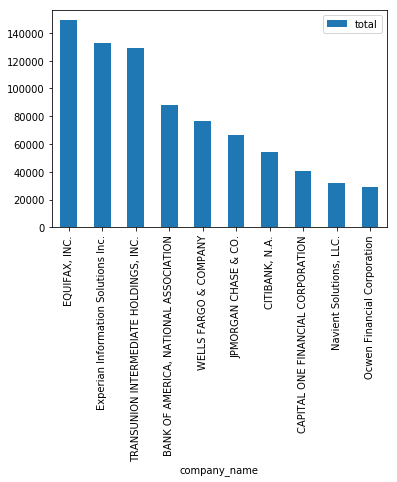

In [20]:
companies_df2[:10].plot(kind='bar', x='company_name',y='total')

# Checking if companies have different spellings

In [49]:
query = """
    SELECT 
        DISTINCT(company_name)
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        company_name LIKE "C%"
    ORDER BY company_name
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

companies_df3 = query_job.to_dataframe()
companies_df3[:30]

,company_name
0,"C & A Mortgage Services of Florence, Inc."
1,"C & E Financial Group, Inc."
2,"C & M Associates Group, Inc."
3,"C & S Auto Enterprises, Inc"
4,C B Merchant Services
5,C&F MORTGAGE CORPORATION
6,"C&H INVESTMENTS, INC."
7,C. Edwin Walker Attorney at Law
8,"C.Tech Collections, Inc."
9,C/C Financial


# Looking at the states sorted by most complaints

In [15]:
query = """
    SELECT 
        state, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        state
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

state_df = query_job.to_dataframe()
state_df

,state,total
0,CA,202756
1,FL,154548
2,TX,127267
3,NY,102472
4,GA,80008
...,...,...
59,MP,34
60,AS,31
61,MH,31
62,AA,27


Looks like data is include from US territories as well.

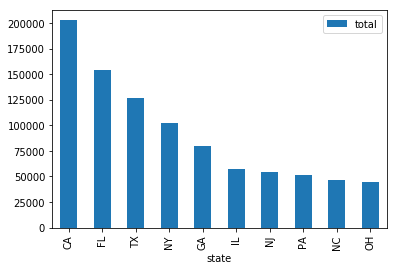

In [18]:
state_df[:10].plot(kind='bar', x='state')

Complaints by state seemed to be correlated by population size.

# Resolution

In [38]:
query = """
    SELECT 
        company_public_response, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        company_public_response
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

response_df = query_job.to_dataframe()
response_df[:10]

,company_public_response,total
0,None,935669
1,Company has responded to the consumer and the ...,411925
2,Company believes it acted appropriately as aut...,71332
3,Company chooses not to provide a public response,52473
4,Company believes the complaint is the result o...,6505
5,Company disputes the facts presented in the co...,5857
6,Company believes complaint caused principally ...,4370
7,Company believes complaint is the result of an...,4292
8,Company believes complaint represents an oppor...,3050
9,Company can't verify or dispute the facts in t...,2515


In [40]:
response_df['company_public_response'][2]

'Company believes it acted appropriately as authorized by contract or law'

In [29]:
query = """
    SELECT 
        company_name, company_public_response, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        company_name, company_public_response
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

response2_df = query_job.to_dataframe()
response2_df[:10]

,company_name,company_public_response,total
0,"EQUIFAX, INC.",None,149169
1,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Company has responded to the consumer and the ...,105131
2,Experian Information Solutions Inc.,Company has responded to the consumer and the ...,103434
3,JPMORGAN CHASE & CO.,None,66211
4,"BANK OF AMERICA, NATIONAL ASSOCIATION",None,47530
5,CAPITAL ONE FINANCIAL CORPORATION,None,40814
6,WELLS FARGO & COMPANY,Company has responded to the consumer and the ...,34847
7,WELLS FARGO & COMPANY,None,33840
8,"BANK OF AMERICA, NATIONAL ASSOCIATION",Company has responded to the consumer and the ...,33223
9,"Navient Solutions, LLC.",None,30849


In [30]:
response2_df[response2_df['company_name']=='EQUIFAX, INC.']

,company_name,company_public_response,total
0,"EQUIFAX, INC.",None,149169
13592,"EQUIFAX, INC.",Company has responded to the consumer and the ...,1


In [32]:
response2_df[response2_df['company_name']=='JPMORGAN CHASE & CO.']

,company_name,company_public_response,total
3,JPMORGAN CHASE & CO.,None,66211
10961,JPMORGAN CHASE & CO.,Company chooses not to provide a public response,1
11474,JPMORGAN CHASE & CO.,Company believes complaint relates to a discon...,1
11640,JPMORGAN CHASE & CO.,Company has responded to the consumer and the ...,1


In [42]:
response2_df[response2_df['company_public_response']=='Company believes it acted appropriately as authorized by contract or law'][:10]

,company_name,company_public_response,total
38,"SELECT PORTFOLIO SERVICING, INC.",Company believes it acted appropriately as aut...,5673
40,ERC,Company believes it acted appropriately as aut...,5317
46,Ditech Financial LLC,Company believes it acted appropriately as aut...,4430
47,UNITED SERVICES AUTOMOBILE ASSOCIATION,Company believes it acted appropriately as aut...,4341
48,NAVY FEDERAL CREDIT UNION,Company believes it acted appropriately as aut...,4154
80,"Shellpoint Partners, LLC",Company believes it acted appropriately as aut...,2094
105,GREAT LAKES,Company believes it acted appropriately as aut...,1419
122,SLM CORPORATION,Company believes it acted appropriately as aut...,1167
140,TCF NATIONAL BANK,Company believes it acted appropriately as aut...,926
142,Phoenix Financial Services LLC,Company believes it acted appropriately as aut...,907


# Looking at date

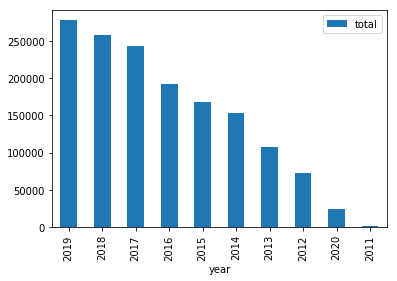

In [47]:
query = """
    SELECT 
        extract(year from date_received) as year, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
       year
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

year_df = query_job.to_dataframe()
year_df.plot(kind='bar', x='year')

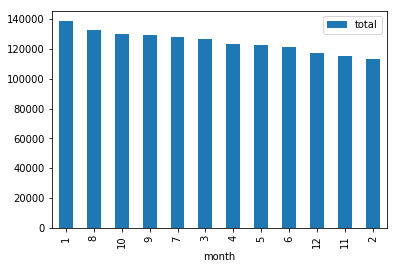

In [48]:
query = """
    SELECT 
        extract(month from date_received) as month, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
       month
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

month_df = query_job.to_dataframe()
month_df.plot(kind='bar', x='month')

In [51]:
query = """
    SELECT 
        date_received, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    GROUP BY
        date_received
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

time_df = query_job.to_dataframe()
time_df

,date_received,total
0,2017-09-08,3553
1,2017-09-09,2709
2,2017-01-19,2070
3,2017-01-20,1633
4,2017-09-13,1600
...,...,...
2985,2012-01-01,14
2986,2011-12-24,11
2987,2011-12-25,10
2988,2017-04-22,9


In [54]:
from datetime import datetime

In [57]:
time_df['date_received'] = pandas.to_datetime(time_df['date_received'])

In [59]:
time_df.set_index('date_received', inplace=True)

In [68]:
time_df

,total
date_received,
2017-09-08,3553
2017-09-09,2709
2017-01-19,2070
2017-01-20,1633
2017-09-13,1600
...,...
2012-01-01,14
2011-12-24,11
2011-12-25,10


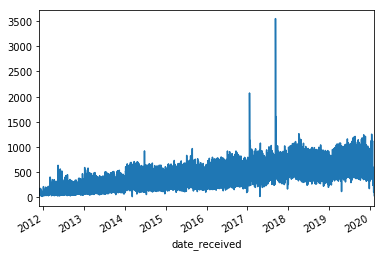

In [67]:
time_df['total'].plot()

In [70]:
dates = pandas.date_range(start='1/1/2017', end='1/1/2018', freq='D')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


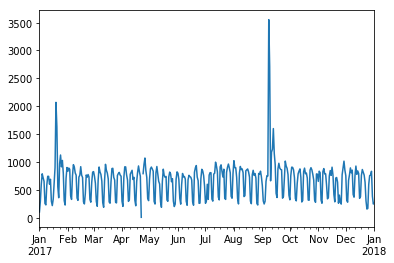

In [77]:
time_df.loc[dates]['total'].plot()

Why those spikes?

In [78]:
dates2 = pandas.date_range(start='1/10/2017', end='1/20/2017', freq='D')

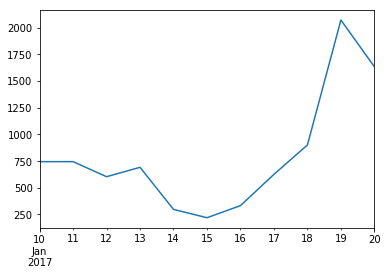

In [80]:
time_df.loc[dates2]['total'].plot()

Low on the weekends, high on Thursday.